# TRABAJO PRACTICO N° 1

## Redes Densas y Convolucionales

---


## Aprendizaje Automático 2
### INTEGRANTES: Moresco, Brisa - Cancio, Jose
### AÑO: 2024 - 2º CUAT.

---



# PROBLEMA 3 - MODELO DE CLASIFICACION CON DISTINTAS REDES NEURONALES

In [1]:
# IMPORTAMOS LAS LIBRERIAS NECESARIAS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Input, Concatenate, RandomFlip, RandomContrast, RandomTranslation, BatchNormalization, Flatten, Dropout
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Rescaling

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

Establecer GPU por defecto en caso de estar disponible

In [2]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


***INFORMACIÓN DEL DATASET***

El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño  150x150, distribuidas en seis categorías:
* buildings
* forest
* glacier
* mountain
* sea
* street

Las imágenes están divididas en tres conjuntos:
* Train: Alrededor de 14,000 imágenes para entrenamiento.
* Test: Alrededor de 3,000 imágenes para evaluación del modelo.
* Prediction: Alrededor de 7,000 imágenes para predicción final.

### Preparación del entorno.

* Instalar gdown

In [3]:

!pip install -q gdown


* Descargar datasets:

In [4]:
import gdown

# TP1-3-natural-scenes.zip
gdown.download('https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ')

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=20141f92-b5cc-45ed-856e-1d49f00b2fb1
To: /content/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:09<00:00, 36.9MB/s]


'TP1-3-natural-scenes.zip'

* Descomprimir datasets:

In [5]:
import zipfile

with zipfile.ZipFile('TP1-3-natural-scenes.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-3')

* Cargar dataset con resolución imágenes igual a la original (150 x 150 pixeles)

In [6]:
# Directorio de los datos
DATA_DIRECTORY = Path("/content/TP1-3/seg_train/seg_train")
# Tamaño del lote (batch size)
BATCH_SIZE = 64
# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH =  150

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [7]:
INPUT_SHAPE=(150, 150, 3)
INPUT_SHAPE

(150, 150, 3)

* Inspeccionar las clases:

In [8]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


* Ver distribucion de frecuencias por clase

In [9]:
from collections import Counter

# Si tienes un dataset de imágenes y etiquetas
class_counts = Counter()

for images, labels in train_ds:
    # Convertir las etiquetas one-hot a etiquetas de clase (índices)
    class_indices = tf.argmax(labels, axis=1).numpy()
    # Actualizar el contador con las etiquetas de clase
    class_counts.update(class_indices)

# Mostrar la cantidad de imágenes por clase, usando los nombres de las clases
for class_id, count in class_counts.items():
    class_name = class_names[class_id]  # Obtener el nombre de la clase
    print(f'Clase {class_name}: {count} imágenes')

Clase glacier: 1941 imágenes
Clase mountain: 2012 imágenes
Clase forest: 1798 imágenes
Clase buildings: 1752 imágenes
Clase street: 1907 imágenes
Clase sea: 1818 imágenes


* Visualizar los datos:

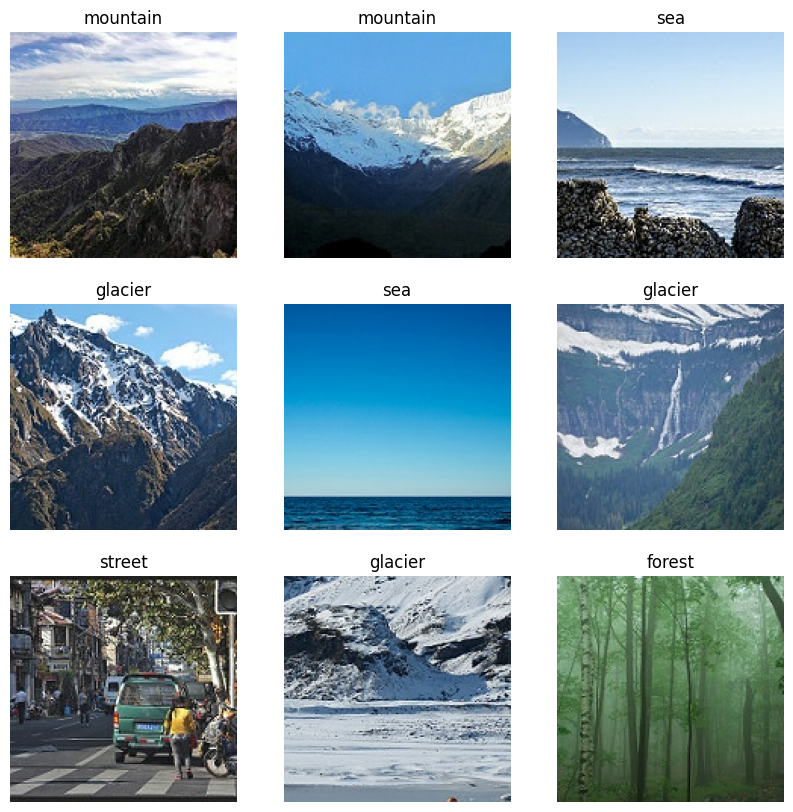

In [10]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

* Otro dataset con resolución imágenes menor a la original (75 x 75 pixeles)

In [11]:
# Directorio de los datos
DATA_DIRECTORY = Path("/content/TP1-3/seg_train/seg_train")
# Tamaño del lote (batch size)
BATCH_SIZE = 64
# Tamaño de las imágenes
IMAGE_HEIGHT = 75
IMAGE_WIDTH =  75

# Carga los datos de entrenamiento y validación
train_ds_low = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds_low = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [12]:
INPUT_SHAPE_LOW=(75, 75, 3)
INPUT_SHAPE_LOW

(75, 75, 3)

### ***CASO 1: MODELO DE RED CON CAPAS DENSAS***

In [ ]:
INPUT_SHAPE #TRABAJAMOS CON EL DATASET DE IMAGENES CON RESOLUCION ORIGINAL (150X150 pixeles)

(150, 150, 3)

In [ ]:
model_seq = Sequential(
    [
        Input(shape=INPUT_SHAPE),       # Dimensión de entrada (150x150x3)
        Flatten(),                      # Aplana las imágenes a un vector 1D
        Rescaling(1./255),              # Normaliza los valores de píxeles entre 0 y 1
        Dense(64, activation="relu"),   # Capa densa con 64 neuronas y activación ReLU
        Dense(6, activation="softmax") # Capa de salida con 6 neuronas (una por clase), activación softmax para clasificación
    ]
)


* Construir el modelo.

In [ ]:
model_seq.compile(optimizer="adam",
                loss='categorical_crossentropy',
                metrics=['accuracy'])


* Resumen del modelo:

In [ ]:
model_seq.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_5 (Rescaling)              │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │       4,320,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,320,454 (16.48 MB)

 Trainable params: 4,320,454 (16.48 MB)

 Non-trainable params: 0 (0.00 B)

* Entrenar el modelo

In [ ]:
history_seq = model_seq.fit(train_ds, epochs=20, validation_data= val_ds)

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.3248 - loss: 6.4649 - val_accuracy: 0.3959 - val_loss: 1.6333
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.4181 - loss: 1.5531 - val_accuracy: 0.3681 - val_loss: 1.7109
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.3309 - loss: 1.6520 - val_accuracy: 0.3161 - val_loss: 1.6178
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.3133 - loss: 1.6191 - val_accuracy: 0.3150 - val_loss: 1.5967
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.2996 - loss: 1.6202 - val_accuracy: 0.3122 - val_loss: 1.5890
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3041 - loss: 1.5919 - val_accuracy: 0.3036 - val_loss: 1.6279
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.3056 - loss: 1.5888 - val_accuracy: 0.3015 - val_loss: 1.6421
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.2976 - loss: 1.5645 - val_ac

* Visualizar resultados de entrenamiento:

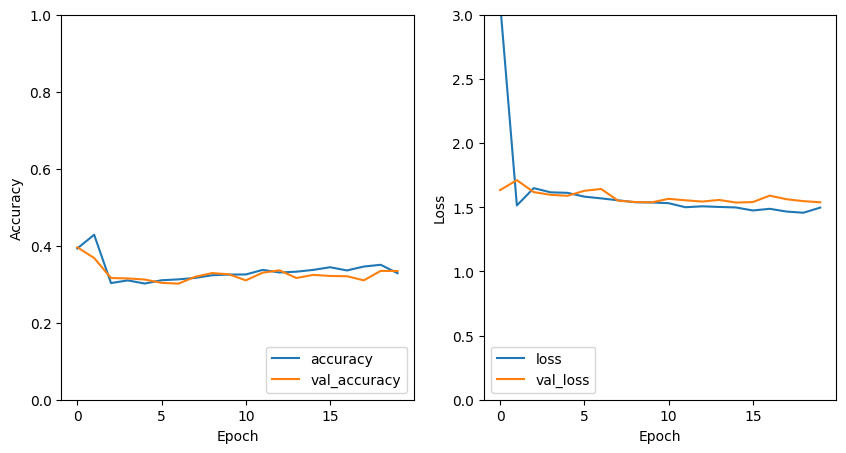

In [ ]:
# Plot the training history, accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_seq.history['accuracy'], label='accuracy')
plt.plot(history_seq.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_seq.history['loss'], label='loss')
plt.plot(history_seq.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower left')


* Observamos que los resultados son muy pobres, tanto para la función de pérdida (loss) como para el 'accuracy'

Entrenamos otro modelo de red densas pero con resolución menor de las imágenes de entrada (75 x 75 pixeles -train_ds_low y val_ds_low)

In [ ]:
INPUT_SHAPE_LOW # TRABAJAMOS CON EL DATASET DE IMAGENES CON RESOLUCION MENOR (75X75 pixeles)

(75, 75, 3)

In [ ]:
model_low = Sequential(
    [
        Input(shape=INPUT_SHAPE_LOW), # MENOR RESOLUCION
        Flatten(),
        Rescaling(1./255),
        Dense(64, activation="relu"),
        Dense(6, activation="softmax"),
    ]
)

* Construir el modelo.

In [ ]:
model_low.compile(optimizer="adam",
                loss='categorical_crossentropy',
                metrics=['accuracy'])


* Resumen del modelo:

In [ ]:
model_low.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 16875)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_24 (Rescaling)             │ (None, 16875)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │       1,080,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,080,454 (4.12 MB)

 Trainable params: 1,080,454 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

* Entrenar el modelo

In [ ]:
# Train the model
history_low = model_low.fit(train_ds_low, epochs=20, validation_data= val_ds_low)

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5777 - loss: 1.1003 - val_accuracy: 0.5613 - val_loss: 1.1849
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5944 - loss: 1.0817 - val_accuracy: 0.5517 - val_loss: 1.1912
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.6012 - loss: 1.0620 - val_accuracy: 0.5613 - val_loss: 1.1630
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6160 - loss: 1.0418 - val_accuracy: 0.5132 - val_loss: 1.2743
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5905 - loss: 1.0777 - val_accuracy: 0.5584 - val_loss: 1.1948
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6101 - loss: 1.0453 - val_accuracy: 0.4797 - val_loss: 1.4183
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6045 - loss: 1.0380 - val_accuracy: 0.5438 - val_loss: 1.2093
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.6193 - loss: 1.0182 - val_accu

* Visualizar resultados de entrenamiento:

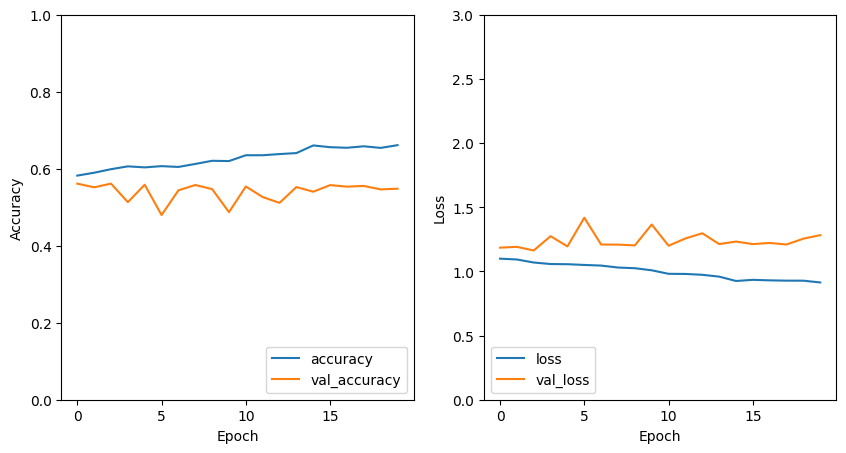

In [ ]:
# Plot the training history, accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_low.history['accuracy'], label='accuracy')
plt.plot(history_low.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_low.history['loss'], label='loss')
plt.plot(history_low.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='lower left')


Observamos que los valores de la funcion de perdida son menores que el modelo anterior, el accuracy mejoro a 0.5481, pero sigue siendo pobre

* Mismo modelo anterior con resolucion de 75 x 75 **pero con mas epocas de entrenamiento**

In [ ]:
# Train the model
history_low_30 = model_low.fit(train_ds_low, epochs=30, validation_data= val_ds_low)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.6603 - loss: 0.9117 - val_accuracy: 0.5385 - val_loss: 1.2573
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6721 - loss: 0.8796 - val_accuracy: 0.5495 - val_loss: 1.2297
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6883 - loss: 0.8503 - val_accuracy: 0.5595 - val_loss: 1.2297
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6843 - loss: 0.8653 - val_accuracy: 0.5574 - val_loss: 1.2195
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.6735 - loss: 0.8654 - val_accuracy: 0.5609 - val_loss: 1.2570
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6912 - loss: 0.8321 - val_accuracy: 0.5431 - val_loss: 1.2532
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6937 - loss: 0.8294 - val_accuracy: 0.5392 - val_loss: 1.2882
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.6966 - loss: 0.8132 - val_acc

Observamos que, respecto del modelo anterior, al aumentar las epocas el accuracy del entrenamiento aumento un poco pero el de validacion disminuyo.Respecto del loss se incremento la difrerencia (bajo el loss del train y aumento el de validacion). Las metricas siguen siendo malas

* Finalmente entrenamos un ultimo modelo de red densas mas complejo (mas capas y neuronas) con resolución menor de las imágenes de entrada (75 x 75 pixeles) y 30 epocas

In [24]:
model_up = Sequential(
    [
        Input(shape=INPUT_SHAPE_LOW),
        Flatten(),  # Flatten the output to 2D
        Rescaling(1./255),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(6, activation="softmax"),
    ]
)

* Construir el modelo.

In [25]:
model_up.compile(optimizer="adam",
                loss='categorical_crossentropy',
                metrics=['accuracy'])


* Resumen del modelo:

In [26]:
model_up.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 16875)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 16875)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │       1,080,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,082,342 (4.13 MB)

 Trainable params: 1,082,342 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

* Entrenar el modelo

In [27]:
history_up = model_up.fit(train_ds_low, epochs=30, validation_data= val_ds_low)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.3432 - loss: 2.0639 - val_accuracy: 0.4886 - val_loss: 1.3178
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.4900 - loss: 1.3301 - val_accuracy: 0.4939 - val_loss: 1.2882
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5202 - loss: 1.2731 - val_accuracy: 0.5196 - val_loss: 1.2480
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5322 - loss: 1.2353 - val_accuracy: 0.5228 - val_loss: 1.2473
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5447 - loss: 1.1967 - val_accuracy: 0.4989 - val_loss: 1.2790
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5646 - loss: 1.1578 - val_accuracy: 0.5549 - val_loss: 1.1723
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5734 - loss: 1.1269 - val_accuracy: 0.5649 - val_loss: 1.1448
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.5867 - loss: 1.1090 - val_accu

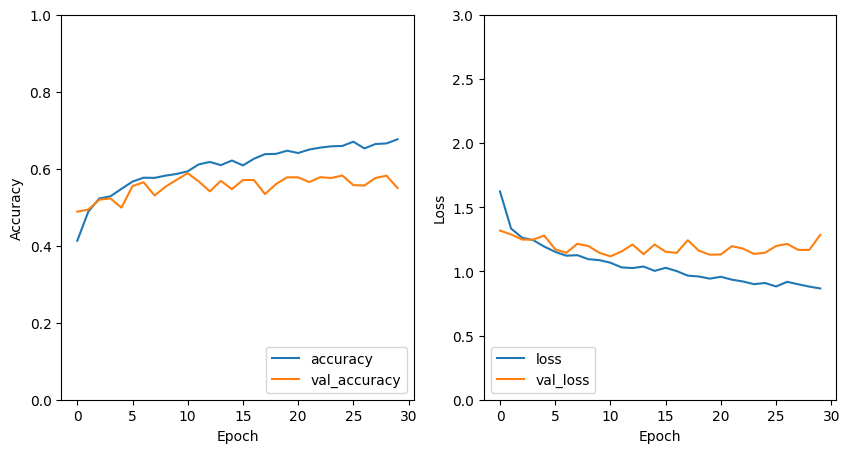

In [28]:
# Plot the training history, accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_up.history['accuracy'], label='accuracy')
plt.plot(history_up.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_up.history['loss'], label='loss')
plt.plot(history_up.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,3])
plt.legend(loc='lower left')


### *** Conclusion Redes Densas:**
  Observamos que estas redes no son buenas para implementar un modelo de prediccion de imagenes con nuestro dataset de entrada. Ya sea bajando la resolucion de entrada de las imagenes, variando las arquitectura de la red (aumentando en ancho y profundidad) y aumentando las epocas de entrenamiento, el resultado es pobre en cuanto al accuracy obtenido (a lo sumo aprox. 0.5499) y la funcion de perdida (loss) siempre por arriba de la de entrenamiento..

### ***CASO 2: MODELO DE RED CON CAPAS CONVOLUCIONALES Y DENSAS***

* Definir la arquitectura de la red:

In [ ]:
INPUT_SHAPE # TRABAJAMOS CON EL DATASET DE IMAGENES CON RESOLUCION ORIGINAL (150X150 pixeles)

(150, 150, 3)

In [ ]:
# Función para construir el modelo
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(8, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

* Construir el modelo:

In [ ]:
print("Building model")
model_conv = build_model(INPUT_SHAPE, num_classes)

model_conv.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


* Resumen del modelo:

In [ ]:
model_conv.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)          │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_27 (Rescaling)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_2 (RandomFlip)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_3 (RandomFlip)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation_1                 │ (None, 150, 150, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_1 (RandomContrast)   │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 148, 148, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 148, 148, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 146, 146, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 146, 146, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 73, 73, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 71, 71, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 71, 71, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 35, 35, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 33, 33, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 33, 33, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 6)                   │          98,310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 6)                   │              

 Total params: 122,838 (479.84 KB)

 Trainable params: 122,838 (479.84 KB)

 Non-trainable params: 0 (0.00 B)

* Entrenar el modelo:

In [ ]:
# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history_conv = model_conv.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.4303 - loss: 1.3725 - val_accuracy: 0.6497 - val_loss: 0.9068
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.6159 - loss: 0.9922 - val_accuracy: 0.6700 - val_loss: 0.8153
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.6604 - loss: 0.8911 - val_accuracy: 0.7263 - val_loss: 0.7468
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7008 - loss: 0.7998 - val_accuracy: 0.7167 - val_loss: 0.7680
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.7247 - loss: 0.7471 - val_accuracy: 0.7598 - val_loss: 0.6662
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7353 - loss: 0.7003 - val_accuracy: 0.7477 - val_loss: 0.6670
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7505 - loss: 0.6667 - val_accuracy: 0.7833 - val_loss: 0.5803
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.7604 - loss: 0.6530 - val_

* Visualizar resultados de entrenamiento:

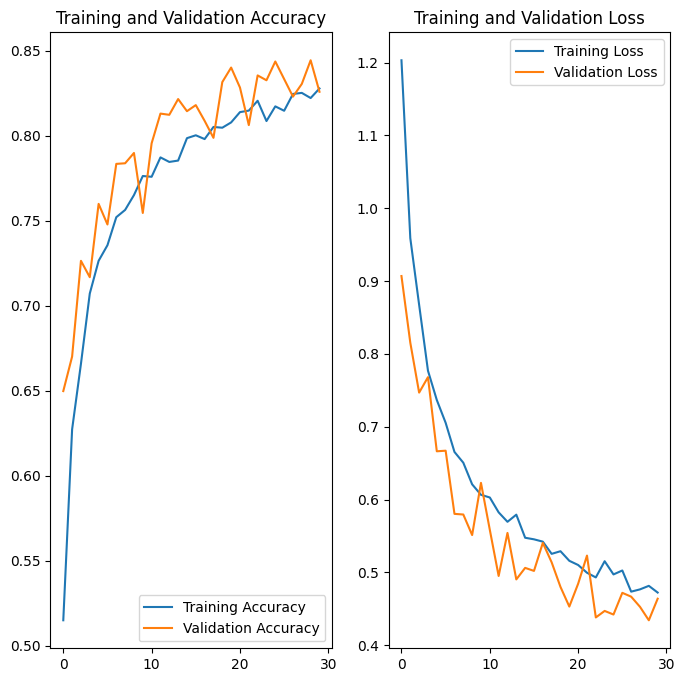

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_conv.history['accuracy']
val_acc = history_conv.history['val_accuracy']

loss = history_conv.history['loss']
val_loss = history_conv.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* Predecir en nuevas imagenes:

In [13]:
# LAS IMAGENES ESTAN CONTENIDAS EN SUBDIRECTORIOS CUYO NOMBRE INDICA LA CLASE A LA QUE PERNENECE CADA IMAGEN.
# OBTENEMOS LOS PATHS DE LAS IMAGENES DE LOS SUBDIRECTORIOS EN FORMA ALEATORIA PARA QUE ESTEN MEZCLADAS
import os
import random

def obtener_imagenes_aleatorias(directorio):
    imagenes = []

    # Recorrer el directorio y sus subdirectorios
    for subdir, _, archivos in os.walk(directorio):
        for archivo in archivos:
            if archivo.endswith('.jpg'):
                # Agregar el path completo de la imagen a la lista
                imagenes.append(os.path.join(subdir, archivo))

    # Mezclar aleatoriamente la lista de imágenes
    random.shuffle(imagenes)

    return imagenes

# Uso de la función
# image_paths= obtener_imagenes_aleatorias(TEST_IMAGES_DIRECTORY)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


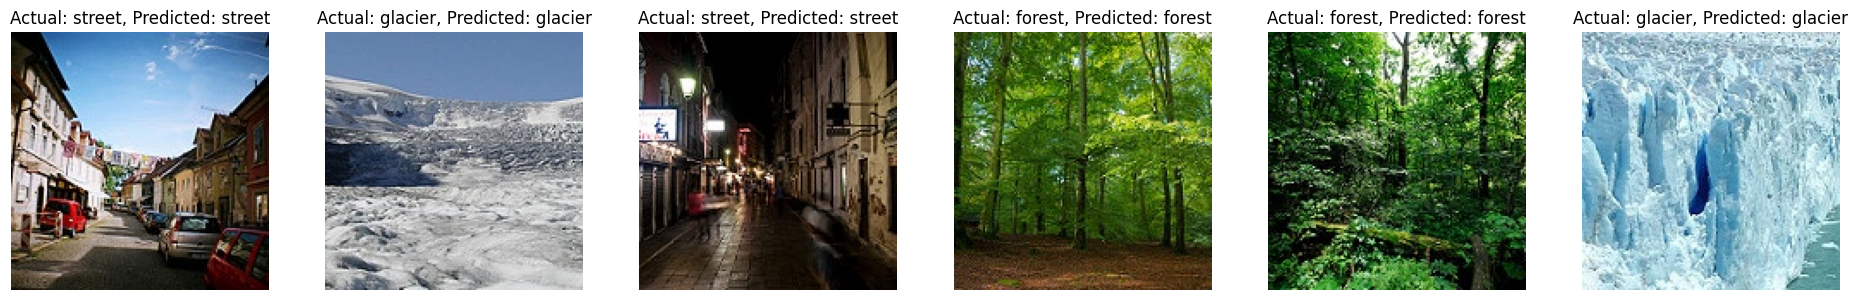

In [ ]:
# PREDECIMOS ALGUNAS IMAGENES NUEVAS

# Funcion para preprocesar la imagen
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Muestra 6 imágenes con sus clases reales y predichas
fig, axes = plt.subplots(1, 6, figsize=(19, 3))

TEST_IMAGES_DIRECTORY = Path("/content/TP1-3/seg_test/seg_test/")

# Obtenemos imagenes en orden aleatorio segun las clases
image_paths= obtener_imagenes_aleatorias(TEST_IMAGES_DIRECTORY)

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)  # Agrega dimension de lote

    # Realizar la prediccion
    prediction = model_conv.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Inicializar la clase actual
    actual_class = ""

    # Obtener el último subdirectorio del path de imagen
    dir_path = os.path.dirname(image_path)  # Obtener el directorio sin el archivo
    last_subdirectory = os.path.basename(dir_path)  # Obtener el nombre del último subdirectorio

    # Comprobar si el último subdirectorio es uno de los tipos de clase
    if last_subdirectory in ["buildings", "forest", "glacier", "mountain", "sea", "street"]:
        actual_class = last_subdirectory

    # Mostrar resultados
    ax.set_title(f"Actual: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

In [ ]:
# VEMOS LAS SUBCARPETAS (ES DECIR, LAS CLASES) DE LAS IMAGENES SELECCIONADAS PARA PREDECIR
image_paths[0:6]

['/content/TP1-3/seg_test/seg_test/street/20818.jpg',
 '/content/TP1-3/seg_test/seg_test/glacier/22924.jpg',
 '/content/TP1-3/seg_test/seg_test/street/22933.jpg',
 '/content/TP1-3/seg_test/seg_test/forest/23502.jpg',
 '/content/TP1-3/seg_test/seg_test/forest/20582.jpg',
 '/content/TP1-3/seg_test/seg_test/glacier/21551.jpg']

* OTRO MODELO CONVOLUCIONAL CON MENOR RESOLUCION EN LAS IMAGENES (75 x 75 pixeles) (train_ds_low y val_ds_low)

In [14]:
INPUT_SHAPE_LOW # TRABAJAMOS CON EL DATASET DE IMAGENES CON RESOLUCION MENOR (75X75 pixeles)

(75, 75, 3)

In [15]:
# Función para construir el modelo
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(8, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

* Construir el modelo:

In [16]:
print("Building model")
model_conv_low = build_model(INPUT_SHAPE_LOW, num_classes)

model_conv_low.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


* Resumen del modelo:

In [17]:
model_conv_low.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 75, 75, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 75, 75, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 75, 75, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_1 (RandomFlip)           │ (None, 75, 75, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 75, 75, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 75, 75, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 73, 73, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 73, 73, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 71, 71, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 71, 71, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 35, 35, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 33, 33, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 33, 33, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │          18,822 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 6)                   │              

 Total params: 43,350 (169.34 KB)

 Trainable params: 43,350 (169.34 KB)

 Non-trainable params: 0 (0.00 B)

* Entrenar el modelo:

In [20]:
# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history_conv_low = model_conv_low.fit(
    train_ds_low,
    validation_data=val_ds_low,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8282 - loss: 0.4652 - val_accuracy: 0.8468 - val_loss: 0.4377
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8350 - loss: 0.4547 - val_accuracy: 0.8357 - val_loss: 0.4564
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.8287 - loss: 0.4728 - val_accuracy: 0.8172 - val_loss: 0.4985
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8326 - loss: 0.4599 - val_accuracy: 0.8389 - val_loss: 0.4494
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8379 - loss: 0.4514 - val_accuracy: 0.8453 - val_loss: 0.4327
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.8351 - loss: 0.4597 - val_accuracy: 0.8457 - val_loss: 0.4344
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8352 - loss: 0.4545 - val_accuracy: 0.8321 - val_loss: 0.4652
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8408 - loss: 0.4443 - val_

* Visualizar resultados de entrenamiento:

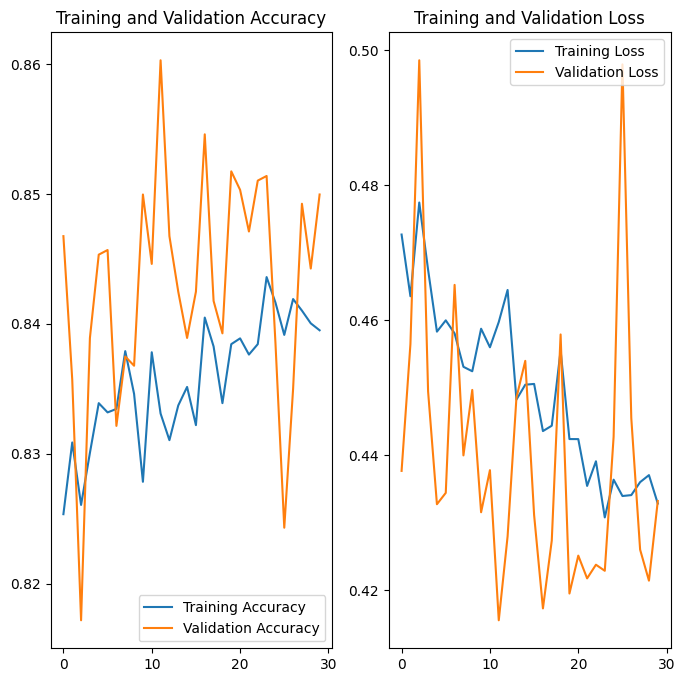

In [21]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_conv_low.history['accuracy']
val_acc = history_conv_low.history['val_accuracy']

loss = history_conv_low.history['loss']
val_loss = history_conv_low.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observamos que los resultados obtenidos, con menor resolucion en las imagenes,  con un accuracy de 0.85, es un poco mejor al primer modelo convolucional con resolucion original (150x150) y el loss de validacion es casi igual al de train.

* Predecir en nuevas imagenes:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


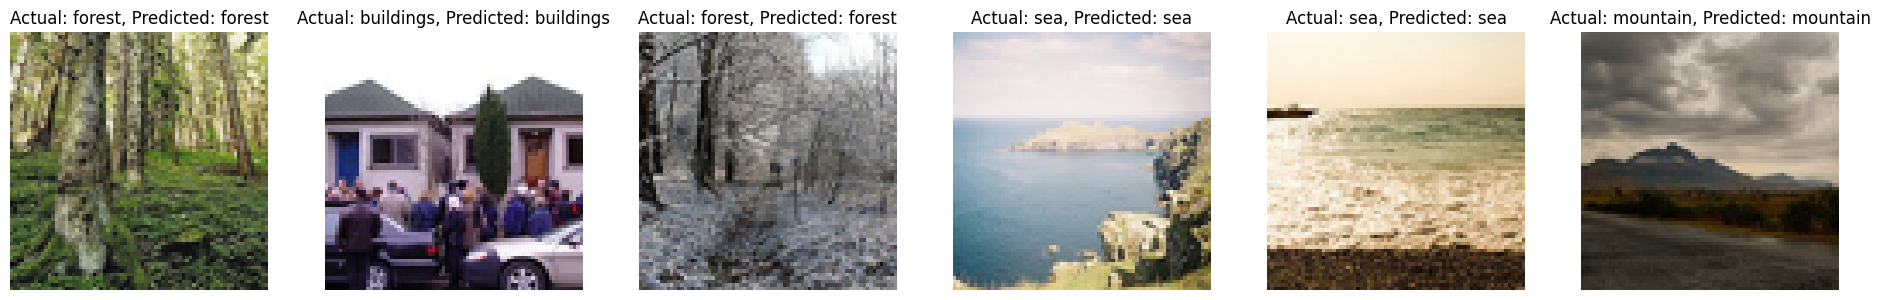

In [ ]:
# PREDECIMOS ALGUNAS IMAGENES NUEVAS

# Funcion para preprocesar la imagen
def preprocess_image(image_path, target_size=(75, 75)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

#  Muestra 6 imagenes con su clase actual y la predicha
fig, axes = plt.subplots(1, 6, figsize=(19, 3))

TEST_IMAGES_DIRECTORY = Path("/content/TP1-3/seg_test/seg_test/")

# Obtenemos imagenes en orden aleatorio segun las clases
image_paths= obtener_imagenes_aleatorias(TEST_IMAGES_DIRECTORY)

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)  # Agrega la dimension del lote

    # Realiza la prediccion
    prediction = model_conv_low.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Inicializar la clase actual
    actual_class = ""

    # Obtener el último subdirectorio del path de imagen
    dir_path = os.path.dirname(image_path)  # Obtener el directorio sin el archivo
    last_subdirectory = os.path.basename(dir_path)  # Obtener el nombre del último subdirectorio

    # Comprobar si el último subdirectorio es uno de los tipos de clase
    if last_subdirectory in ["buildings", "forest", "glacier", "mountain", "sea", "street"]:
        actual_class = last_subdirectory

    # Muestra los resultados
    ax.set_title(f"Actual: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

In [ ]:
# VEMOS LAS SUBCARPETAS (ES DECIR, LAS CLASES) DE LAS IMAGENES SELECCIONADAS PARA PREDECIR
image_paths[0:6]

['/content/TP1-3/seg_test/seg_test/forest/23852.jpg',
 '/content/TP1-3/seg_test/seg_test/buildings/22341.jpg',
 '/content/TP1-3/seg_test/seg_test/forest/23031.jpg',
 '/content/TP1-3/seg_test/seg_test/sea/23549.jpg',
 '/content/TP1-3/seg_test/seg_test/sea/23351.jpg',
 '/content/TP1-3/seg_test/seg_test/mountain/21915.jpg']

* Mismo modelo con resolucion mas baja en imagenes **pero con solo 10 epocas de entrenamiento**

In [22]:
# Número de épocas de entrenamiento
EPOCHS = 10
# Entrena el modelo
history_conv_low_10ep = model_conv_low.fit(
    train_ds_low,
    validation_data=val_ds_low,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8459 - loss: 0.4254 - val_accuracy: 0.8418 - val_loss: 0.4450
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8441 - loss: 0.4317 - val_accuracy: 0.8510 - val_loss: 0.4153
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8473 - loss: 0.4155 - val_accuracy: 0.8439 - val_loss: 0.4274
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8440 - loss: 0.4156 - val_accuracy: 0.8525 - val_loss: 0.4158
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8426 - loss: 0.4202 - val_accuracy: 0.8496 - val_loss: 0.4210
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.8492 - loss: 0.4158 - val_accuracy: 0.8432 - val_loss: 0.4305
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.8519 - loss: 0.4300 - val_accuracy: 0.8393 - val_loss: 0.4518
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8492 - loss: 0.4053 - val_a

### *** Conclusion Redes Convolucionales:**
  Observamos que las redes convolucionales (CNN) son más efectivas y eficientes para clasificar imágenes en comparación con las redes densas. Las CNN pueden aprender automáticamente las características relevantes de las imágenes, como bordes, texturas y formas, sin necesidad de extracción manual. En nuestro caso, dada una misma arquitectectura de la red, se fue bajando la resolucion de las imagenes, las epocas de entrenamiento, obteniendo como resultado final un modelo entrenado con mas baja resolucion y solo 10 epocas de train (su accuracy apenas mas bajo que el entrenado con 30 epocas).

### ***CASO 3: MODELO DE RED CON BLOQUES RESIDUALES IDENTIDAD (RESNET)***

* Definir la arquitectura de la red:

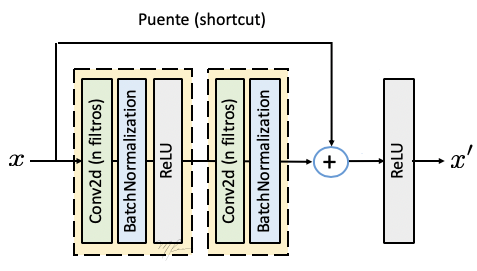

In [ ]:
INPUT_SHAPE

(150, 150, 3)

* RED RESIDUAL DISTINTA CON 1 BLOQUE RESIDUAL

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definimos un bloque residual básico
def res_block(x, filters):
    # Shortcut (conexión de salto)
    shortcut = x

    # Primer bloque convolucional
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Segundo bloque convolucional
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Agregar la conexión de salto
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)

    return x

# Definimos la arquitectura de ResNet
def build_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x= Rescaling(1./255)(inputs)

    # Capa inicial
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Cantidad de bloques residuales      1 BLOQUE RESIDUAL ....................
    for _ in range(1):
        x = res_block(x, 64)

    # Capa de global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Parámetros de configuración
input_shape = INPUT_SHAPE  # Formato de imagen de entrada
num_classes = 6  # Número de clases para la clasificación

# Construir el modelo
model_resnet = build_resnet(input_shape, num_classes)

# Compilar el modelo
model_resnet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model_resnet.summary()

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34            │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_177 (Rescaling) │ (None, 150, 150, 3)    │              0 │ input_layer_34[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 75, 75, 64)     │          9,472 │ rescaling_177[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_84    │ (None, 75, 75, 64)     │            256 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_81 (ReLU)           │ (None, 75, 75, 64)     │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_24          │ (None, 38, 38, 64)     │              0 │ re_lu_81[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 38, 38, 64)     │         36,928 │ max_pooling2d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_85    │ (None, 38, 38, 64)     │            256 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_82 (ReLU)           │ (None, 38, 38, 64)     │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 38, 38, 64)     │         36,928 │ re_lu_82[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_86    │ (None, 38, 38, 64)     │            256 │ conv2d_98[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_33 (Add)              │ (None, 38, 38, 64)     │              0 │ batch_normalization_8… │
│                           │                        │                │ max_pooling2d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_83 (ReLU)           │ (None, 38, 38, 64)     │              0 │ add_33[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ re_lu_83[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_41 (Dense)          │ (None, 6)              │            390 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 84,486 (330.02 KB)

 Trainable params: 84,102 (328.52 KB)

 Non-trainable params: 384 (1.50 KB)

* Entrenar el modelo

In [ ]:
# Entrenar el modelo
history_resnet= model_resnet.fit(train_ds, epochs=20, validation_data=  val_ds)

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9508 - loss: 0.1406 - val_accuracy: 0.6483 - val_loss: 2.5814
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9490 - loss: 0.1424 - val_accuracy: 0.6957 - val_loss: 1.7367
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9522 - loss: 0.1404 - val_accuracy: 0.7099 - val_loss: 1.5516
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9454 - loss: 0.1433 - val_accuracy: 0.7085 - val_loss: 1.5812
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9457 - loss: 0.1475 - val_accuracy: 0.6540 - val_loss: 2.5968
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9496 - loss: 0.1389 - val_accuracy: 0.6123 - val_loss: 3.2556
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9481 - loss: 0.1464 - val_accuracy: 0.6800 - val_loss: 1.4844
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9566 - loss: 0.1283 - val_

* Visualizar resultados de entrenamiento:

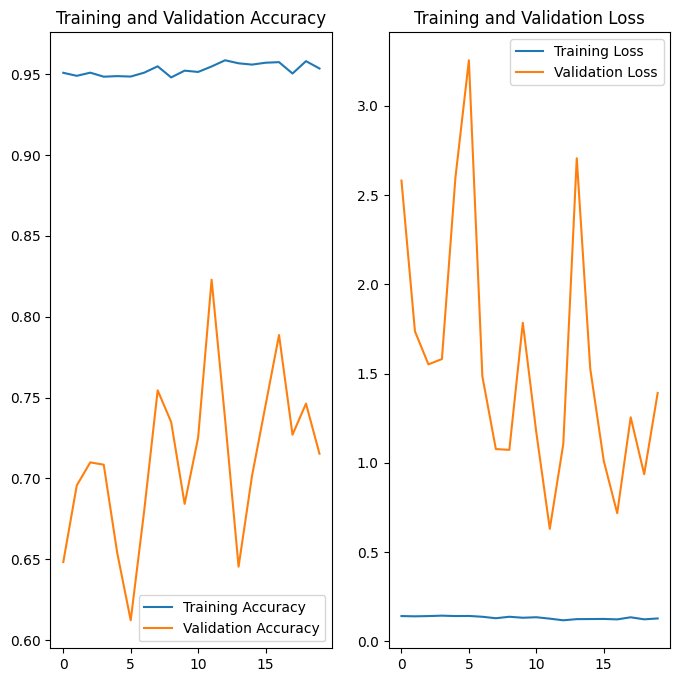

In [ ]:
EPOCHS = 20
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']

loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Continuamos con la Evaluacion del modelo y las inferencias

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


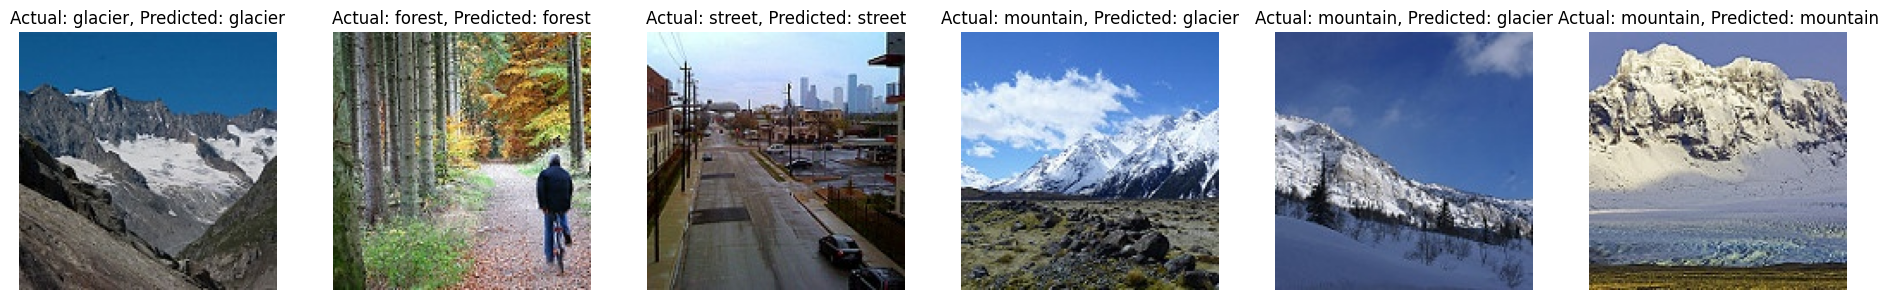

In [ ]:
# PREDECIMOS ALGUNAS IMAGENES NUEVAS

# Funcion para procesar la imagen
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Muestra 6 imagenes con su clase actual y la predicha
fig, axes = plt.subplots(1, 6, figsize=(19, 3))

TEST_IMAGES_DIRECTORY = Path("/content/TP1-3/seg_test/seg_test/")

# Uso de la función
image_paths= obtener_imagenes_aleatorias(TEST_IMAGES_DIRECTORY)

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)  # Agrega la dimension del lote

    # Realiza la prediccion
    prediction = model_resnet.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Inicializar la clase actual
    actual_class = ""

    # Obtener el último subdirectorio del path de imagen
    dir_path = os.path.dirname(image_path)  # Obtener el directorio sin el archivo
    last_subdirectory = os.path.basename(dir_path)  # Obtener el nombre del último subdirectorio

    # Comprobar si el último subdirectorio es uno de los tipos de clase
    if last_subdirectory in ["buildings", "forest", "glacier", "mountain", "sea", "street"]:
        actual_class = last_subdirectory

    # Muestra los resultados
    ax.set_title(f"Actual: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

In [ ]:
image_paths[0:6]

['/content/TP1-3/seg_test/seg_test/glacier/23655.jpg',
 '/content/TP1-3/seg_test/seg_test/forest/22355.jpg',
 '/content/TP1-3/seg_test/seg_test/street/21185.jpg',
 '/content/TP1-3/seg_test/seg_test/mountain/22868.jpg',
 '/content/TP1-3/seg_test/seg_test/mountain/20940.jpg',
 '/content/TP1-3/seg_test/seg_test/mountain/21691.jpg']

* RED RESIDUAL DISTINTA CON 2 BLOQUES RESIDUALES

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definimos un bloque residual básico
def res_block(x, filters):
    # Shortcut (conexión de salto)
    shortcut = x

    # Primer bloque convolucional
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Segundo bloque convolucional
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Agregar la conexión de salto
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)

    return x

# Definimos la arquitectura de ResNet
def build_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x= Rescaling(1./255)(inputs)

    # Capa inicial
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Cantidad de bloques residuales - AHORA 2 BLOQUES RESIDUALES ··················
    for _ in range(2):
        x = res_block(x, 64)

    # Capa de global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Parámetros de configuración
input_shape = INPUT_SHAPE  # Formato de imagen de entrada
num_classes = 6  # Número de clases para la clasificación

# Construir el modelo
model_resnet_2 = build_resnet(input_shape, num_classes)

# Compilar el modelo
model_resnet_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model_resnet_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 75, 75, 64)     │          9,472 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 75, 75, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 75, 75, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 38, 38, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 38, 38, 64)     │         36,928 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 38, 38, 64)     │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 38, 38, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 38, 38, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 38, 38, 64)     │            256 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 38, 38, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 38, 38, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 38, 38, 64)     │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 38, 38, 64)     │            256 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 38, 38, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 38, 38, 64)     │         36,928 │ re_lu_3[0][0]          │
├──────────────────────

 Total params: 158,854 (620.52 KB)

 Trainable params: 158,214 (618.02 KB)

 Non-trainable params: 640 (2.50 KB)

* Entrenar el modelo

In [ ]:
# Entrenar el modelo
history_resnet_2= model_resnet_2.fit(train_ds, epochs=20, validation_data=  val_ds)

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.5862 - loss: 1.0851 - val_accuracy: 0.2014 - val_loss: 3.6963
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.7372 - loss: 0.7173 - val_accuracy: 0.4498 - val_loss: 2.1419
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.7833 - loss: 0.6279 - val_accuracy: 0.3952 - val_loss: 2.4751
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.7970 - loss: 0.5764 - val_accuracy: 0.5584 - val_loss: 1.2063
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.8091 - loss: 0.5211 - val_accuracy: 0.6397 - val_loss: 0.9171
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.8220 - loss: 0.4919 - val_accuracy: 0.5374 - val_loss: 1.5923
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.8366 - loss: 0.4645 - val_accuracy: 0.5527 - val_loss: 1.7406
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.8397 - loss: 0.4518 - val

* Visualizar resultados de entrenamiento:

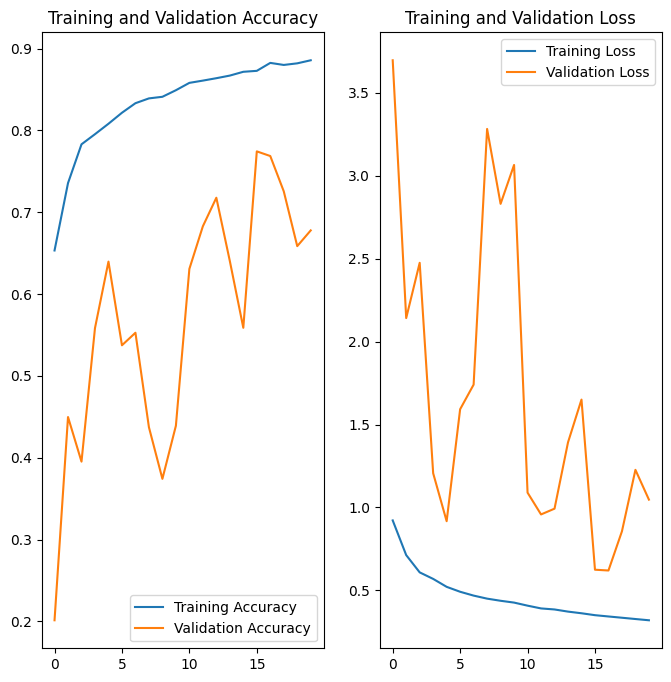

In [ ]:
EPOCHS = 20
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_resnet_2.history['accuracy']
val_acc = history_resnet_2.history['val_accuracy']

loss = history_resnet_2.history['loss']
val_loss = history_resnet_2.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* RED RESIDUAL DISTINTA CON 3 BLOQUES RESIDUALES

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definimos un bloque residual básico
def res_block(x, filters):
    # Shortcut (conexión de salto)
    shortcut = x

    # Primer bloque convolucional
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Segundo bloque convolucional
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Agregar la conexión de salto
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)

    return x

# Definimos la arquitectura de ResNet
def build_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x= Rescaling(1./255)(inputs)

    # Capa inicial
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Cantidad de bloques residuales   AHORA 3 BLOQUES RESIDUALES .......................
    for _ in range(3):
        x = res_block(x, 64)

    # Capa de global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Parámetros de configuración
input_shape = INPUT_SHAPE  # Formato de imagen de entrada
num_classes = 6  # Número de clases para la clasificación

# Construir el modelo
model_resnet_3 = build_resnet(input_shape, num_classes)

# Compilar el modelo
model_resnet_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model_resnet_3.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38            │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_116 (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ input_layer_38[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_104   │ (None, 75, 75, 64)     │            256 │ conv2d_116[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_101 (ReLU)          │ (None, 75, 75, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_28          │ (None, 38, 38, 64)     │              0 │ re_lu_101[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_117 (Conv2D)       │ (None, 38, 38, 64)     │         36,928 │ max_pooling2d_28[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_105   │ (None, 38, 38, 64)     │            256 │ conv2d_117[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_102 (ReLU)          │ (None, 38, 38, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_118 (Conv2D)       │ (None, 38, 38, 64)     │         36,928 │ re_lu_102[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_106   │ (None, 38, 38, 64)     │            256 │ conv2d_118[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_41 (Add)              │ (None, 38, 38, 64)     │              0 │ batch_normalization_1… │
│                           │                        │                │ max_pooling2d_28[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_103 (ReLU)          │ (None, 38, 38, 64)     │              0 │ add_41[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_119 (Conv2D)       │ (None, 38, 38, 64)     │         36,928 │ re_lu_103[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_107   │ (None, 38, 38, 64)     │            256 │ conv2d_119[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_104 (ReLU)          │ (None, 38, 38, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_120 (Conv2D)       │ (None, 38, 38, 64)     │         36,928 │ re_lu_104[0][0]        │
├──────────────────────

 Total params: 233,222 (911.02 KB)

 Trainable params: 232,326 (907.52 KB)

 Non-trainable params: 896 (3.50 KB)

* Entrenar el modelo

In [ ]:
# Entrenar el modelo
history_resnet_3= model_resnet_3.fit(train_ds, epochs=20, validation_data=  val_ds)

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9203 - loss: 0.2269 - val_accuracy: 0.7915 - val_loss: 0.5830
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9186 - loss: 0.2345 - val_accuracy: 0.6461 - val_loss: 1.1927
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.9174 - loss: 0.2356 - val_accuracy: 0.7206 - val_loss: 1.0550
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.9249 - loss: 0.2209 - val_accuracy: 0.7908 - val_loss: 0.5813
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.9271 - loss: 0.2148 - val_accuracy: 0.7855 - val_loss: 0.5974
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.9268 - loss: 0.2086 - val_accuracy: 0.7837 - val_loss: 0.6118
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9229 - loss: 0.2079 - val_accuracy: 0.7876 - val_loss: 0.7127
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.9278 - loss: 0.2006 - 

* Visualizar resultados de entrenamiento:

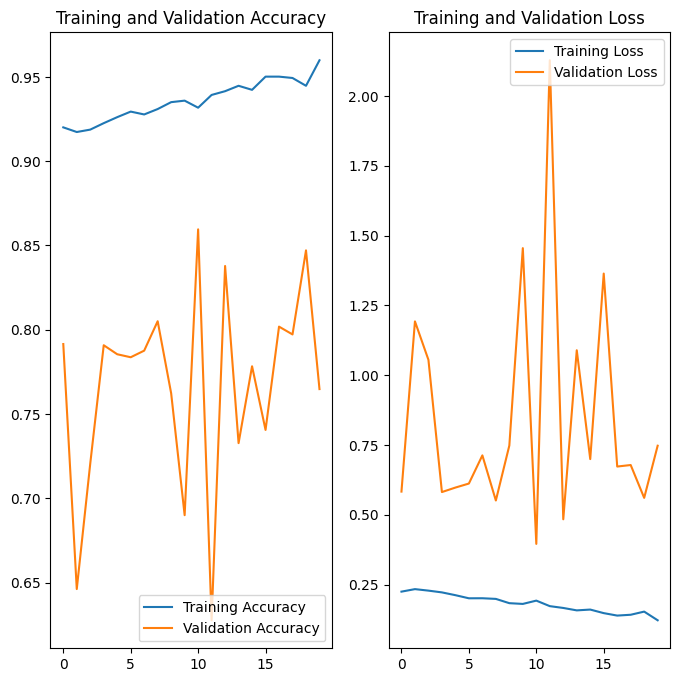

In [ ]:
EPOCHS = 20
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_resnet_3.history['accuracy']
val_acc = history_resnet_3.history['val_accuracy']

loss = history_resnet_3.history['loss']
val_loss = history_resnet_3.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* CAMBIAMOS (BAJAMOS) LA RESOLUCION DE LAS IMAGENES A LA MITAD (train_ds_low, val_ds_low)

In [ ]:
INPUT_SHAPE_LOW

(75, 75, 3)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definimos un bloque residual básico
def res_block(x, filters):
    # Shortcut (conexión de salto)
    shortcut = x

    # Primer bloque convolucional
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Segundo bloque convolucional
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Agregar la conexión de salto
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)

    return x

# Definimos la arquitectura de ResNet
def build_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x= Rescaling(1./255)(inputs)

    # Capa inicial
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Cantidad de bloques residuales
    for _ in range(1):
        x = res_block(x, 64)

    # Capa de global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Parámetros de configuración
input_shape = INPUT_SHAPE_LOW # Formato de imagen de entrada
num_classes = 6  # Número de clases para la clasificación

# Construir el modelo
model_resnet_low = build_resnet(input_shape, num_classes)

# Compilar el modelo
model_resnet_low.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model_resnet_low.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28            │ (None, 75, 75, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 38, 38, 64)     │          9,472 │ input_layer_28[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_57    │ (None, 38, 38, 64)     │            256 │ conv2d_65[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_56 (ReLU)           │ (None, 38, 38, 64)     │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 19, 19, 64)     │              0 │ re_lu_56[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 19, 19, 64)     │         36,928 │ max_pooling2d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_58    │ (None, 19, 19, 64)     │            256 │ conv2d_66[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_57 (ReLU)           │ (None, 19, 19, 64)     │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_67 (Conv2D)        │ (None, 19, 19, 64)     │         36,928 │ re_lu_57[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_59    │ (None, 19, 19, 64)     │            256 │ conv2d_67[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_22 (Add)              │ (None, 19, 19, 64)     │              0 │ batch_normalization_5… │
│                           │                        │                │ max_pooling2d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_58 (ReLU)           │ (None, 19, 19, 64)     │              0 │ add_22[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ re_lu_58[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_36 (Dense)          │ (None, 6)              │            390 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 84,486 (330.02 KB)

 Trainable params: 84,102 (328.52 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# Entrenar el PRIMER MODELO RESNET CON UN SOLO BLOQUE RESIDUAL (model_resnet)
history_resnet_low= model_resnet_low.fit(train_ds_low, epochs=20, validation_data=  val_ds_low)

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8396 - loss: 0.4693 - val_accuracy: 0.3949 - val_loss: 2.2060
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.8379 - loss: 0.4509 - val_accuracy: 0.6468 - val_loss: 1.0042
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.8431 - loss: 0.4523 - val_accuracy: 0.6604 - val_loss: 0.9845
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8483 - loss: 0.4272 - val_accuracy: 0.7359 - val_loss: 0.7820
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.8518 - loss: 0.4277 - val_accuracy: 0.5952 - val_loss: 1.4789
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8541 - loss: 0.4207 - val_accuracy: 0.6251 - val_loss: 1.3085
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8529 - loss: 0.4184 - val_accuracy: 0.6554 - val_loss: 1.1477
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8608 - loss: 0.3952 - val_ac

* Visualizar resultados de entrenamiento:

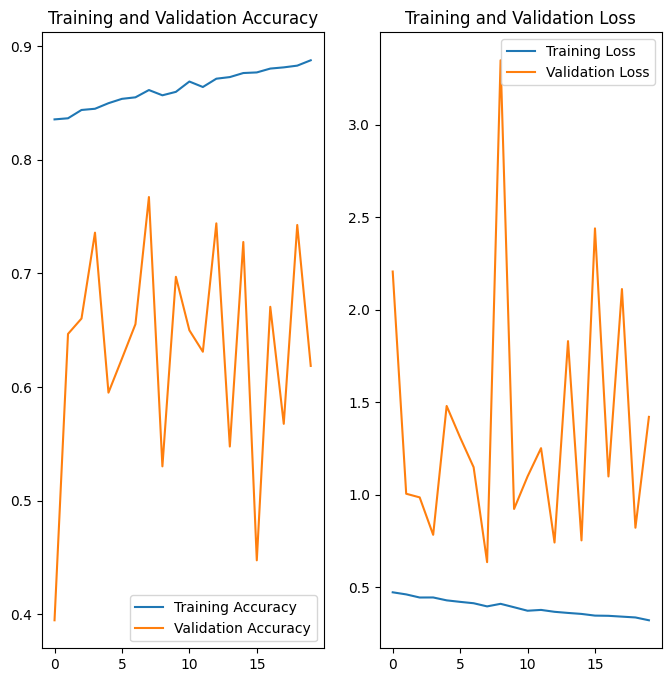

In [ ]:
EPOCHS = 20
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_resnet_low.history['accuracy']
val_acc = history_resnet_low.history['val_accuracy']

loss = history_resnet_low.history['loss']
val_loss = history_resnet_low.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* ENTRENAMOS AHORA UN MODELO RESIDUAL MUCHO MAS PROFUNDO QUE LOS ANTERIORES

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models

def res_block(x, filters, strides=1): #agregamos strides como parametro
    shortcut = x
    x = layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    #Manejo de la conexión de salto para diferentes dimensiones
    if strides != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x= Rescaling(1./255)(inputs)

    # Capa inicial
    x = layers.Conv2D(16, kernel_size=7, strides=2, padding='same')(inputs)  # PROBAR CON 16 flitros
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Etapa 1
    x = res_block(x, 16)                                                     # Y DESDE ACA PROBAR CON 16, 32 FILTROS
    x = res_block(x, 16)

    # Etapa 2
    x = res_block(x, 32, strides=2) # Incrementamos los filtros y usamos strides=2
    x = res_block(x, 32)
    x = res_block(x, 32)

    # Capa de global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Parámetros de configuración
input_shape = INPUT_SHAPE  # Formato de imagen de entrada
num_classes = 6  # Número de clases para la clasificación

# Construir el modelo
model_resnet_super = build_resnet(input_shape, num_classes)

# Compilar el modelo
model_resnet_super.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model_resnet_super.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 75, 75, 16)     │          2,368 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 75, 75, 16)     │             64 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 75, 75, 16)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 38, 38, 16)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 38, 38, 16)     │          2,320 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 38, 38, 16)     │             64 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 38, 38, 16)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 38, 38, 16)     │          2,320 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 38, 38, 16)     │             64 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 38, 38, 16)     │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 38, 38, 16)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 38, 38, 16)     │          2,320 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 38, 38, 16)     │             64 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 38, 38, 16)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 38, 38, 16)     │          2,320 │ re_lu_3[0][0]          │
├──────────────────────

 Total params: 64,486 (251.90 KB)

 Trainable params: 63,878 (249.52 KB)

 Non-trainable params: 608 (2.38 KB)

In [31]:
# Entrenar el PRIMER MODELO RESNET CON UN SOLO BLOQUE RESIDUAL (model_resnet)
history_resnet_super= model_resnet_super.fit(train_ds, epochs=20, validation_data=  val_ds)

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9136 - loss: 0.2427 - val_accuracy: 0.7046 - val_loss: 0.8771
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9179 - loss: 0.2377 - val_accuracy: 0.8268 - val_loss: 0.4875
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9229 - loss: 0.2171 - val_accuracy: 0.6144 - val_loss: 1.6349
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9280 - loss: 0.2109 - val_accuracy: 0.8068 - val_loss: 0.5676
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9218 - loss: 0.2061 - val_accuracy: 0.8150 - val_loss: 0.5924
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9293 - loss: 0.1978 - val_accuracy: 0.7591 - val_loss: 0.6974
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9325 - loss: 0.1922 - val_accuracy: 0.5987 - val_loss: 1.4824
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9385 - loss: 0.1734 - val

Visualizamos las metricas

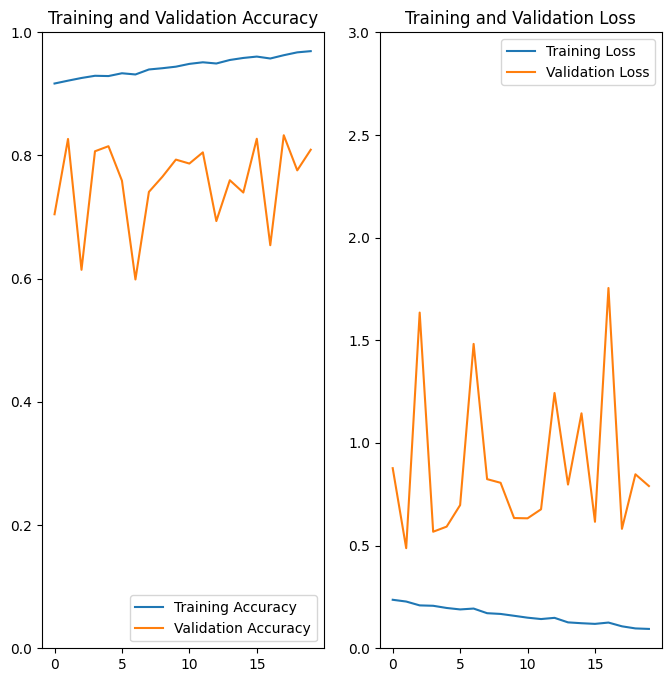

In [34]:
EPOCHS = 20
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_resnet_super.history['accuracy']
val_acc = history_resnet_super.history['val_accuracy']

loss = history_resnet_super.history['loss']
val_loss = history_resnet_super.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0,3])
plt.title('Training and Validation Loss')
plt.show()

### *** Conclusion Redes Residuales:**
  Las redes residuales (ResNet) son una evolución de las redes neuronales convolucionales (CNN) que ofrecen ventajas adicionales en la clasificación de imágenes, al utilizar bloques de conexión residual, que permiten que la información fluya más fácilmente a través de la red. Esto facilita el entrenamiento de redes más profundas sin problemas de desvanecimiento del gradiente, lo que permite una representación más rica y compleja de los datos, mejorando la precisión en tareas de clasificación.

  En nuestro caso, se fue probando con diferente cantidad de bloques residuales, bajando la resolucion de las imagenes, hasta entrenar por ultimo con un modelo de varios bloques residuales (a los cuales se le fue bajando la cantidad de filtros de la ultima etapa (128 -> 64 -> 32)) hasta obtener los mejores resultados entre las redes Resnet.    

### ***CASO 4: MODELO DE RED QUE UTILICE BACKBONE (TRANSFER LEARNING)***

* CAMBIAMOS EL TAMAÑO DE LAS IMAGENES DEL DATASET AL TAMAÑO ESPECIFICO QUE NECESITA EL MODELO DE TRANSFER LEARNING ELEGIDO ("EfficienNet" - https://arxiv.org/pdf/1905.11946)

In [37]:
# Directorio de los datos
DATA_DIRECTORY = Path("/content/TP1-3/seg_train/seg_train")
# Tamaño del lote (batch size)
BATCH_SIZE = 32
# Tamaño de las imágenes
IMAGE_HEIGHT = 224
IMAGE_WIDTH =  224

# Carga los datos de entrenamiento y validación
train_ds_224 = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds_224 = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


Definir la arquitectura de la red:

In [38]:
INPUT_SHAPE_224 = (224, 224, 3)
INPUT_SHAPE_224

(224, 224, 3)

In [ ]:
def build_model(input_shape, num_classes):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(i, x)

Construir el modelo:

In [ ]:
print("Building model")
model_transfer = build_model((INPUT_SHAPE_224), num_classes)

model_transfer.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Resumen del modelo:

In [ ]:
model_transfer.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 1280)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │           7,686 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,057,257 (15.48 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Entrenar el modelo:

In [ ]:
# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history_transfer = model_transfer.fit(
    train_ds_224,
    validation_data=val_ds_224,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 118ms/step - accuracy: 0.7141 - loss: 0.9275 - val_accuracy: 0.8660 - val_loss: 0.4351
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.8729 - loss: 0.3859 - val_accuracy: 0.8738 - val_loss: 0.3893
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.8895 - loss: 0.3313 - val_accuracy: 0.8902 - val_loss: 0.3638
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.9030 - loss: 0.2862 - val_accuracy: 0.8852 - val_loss: 0.3945
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9059 - loss: 0.2620 - val_accuracy: 0.8885 - val_loss: 0.3652
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.9067 - loss: 0.2608 - val_accuracy: 0.8820 - val_loss: 0.3897
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9162 - loss: 0.2332 - val_accuracy: 0.8899 - val_loss: 0.3955
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.9199 - loss: 0.2216 -

Visualizar resultados de entrenamiento:

In [ ]:
EPOCHS= 30

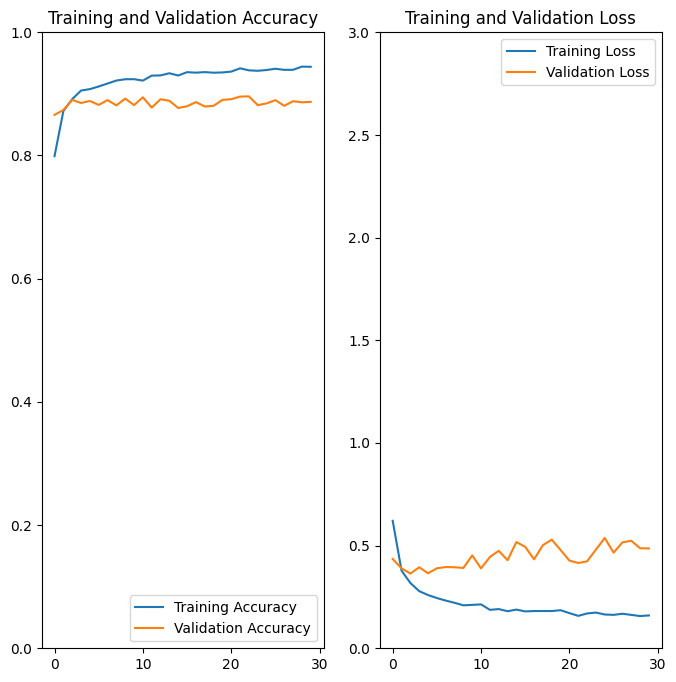

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']

loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0, 3])
plt.title('Training and Validation Loss')
plt.show()

Predecir en nuevas imagenes:

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


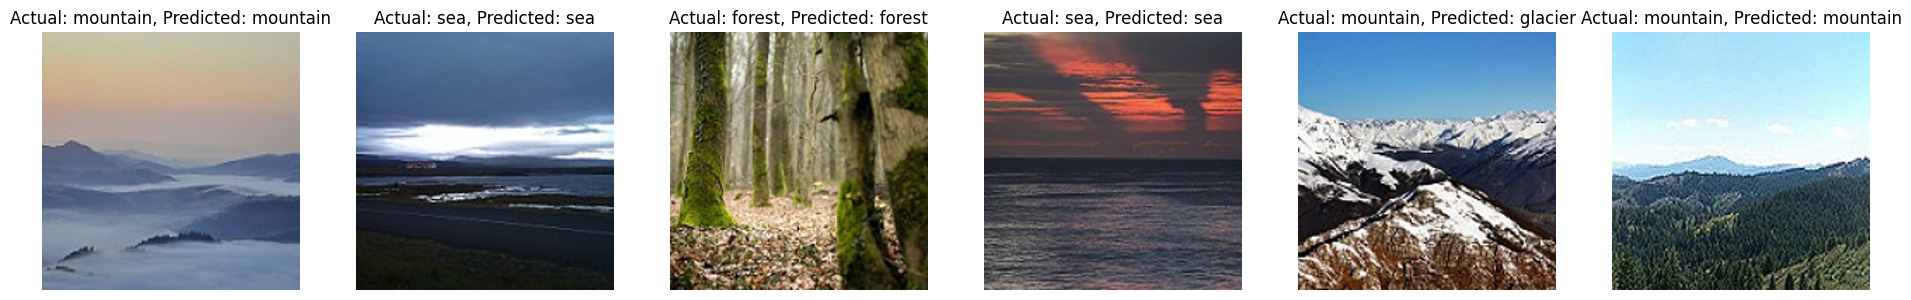

In [ ]:
import os

# Funcion para preprocesar la imagen
def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Muestra 6 imagenes con su clase actual y la predicha
fig, axes = plt.subplots(1, 6, figsize=(19, 3))

TEST_IMAGES_DIRECTORY = Path("/content/TP1-3/seg_test/seg_test/")

# Uso de la función
image_paths= obtener_imagenes_aleatorias(TEST_IMAGES_DIRECTORY)

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)  # Agrega la dimension del lote

    # Realiza la  prediccion
    prediction = model_transfer.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Inicializar la clase actual
    actual_class = ""

    # Obtener el último subdirectorio del camino de imagen
    dir_path = os.path.dirname(image_path)  # Obtener el directorio sin el archivo
    last_subdirectory = os.path.basename(dir_path)  # Obtener el nombre del último subdirectorio

    # Comprobar si el último subdirectorio es uno de los tipos de clase
    if last_subdirectory in ["buildings", "forest", "glacier", "mountain", "sea", "street"]:
        actual_class = last_subdirectory

    # Muestra los resultados
    ax.set_title(f"Actual: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

In [ ]:
image_paths[0:6]

['/content/TP1-3/seg_test/seg_test/mountain/21613.jpg',
 '/content/TP1-3/seg_test/seg_test/sea/20909.jpg',
 '/content/TP1-3/seg_test/seg_test/forest/22028.jpg',
 '/content/TP1-3/seg_test/seg_test/sea/22386.jpg',
 '/content/TP1-3/seg_test/seg_test/mountain/20980.jpg',
 '/content/TP1-3/seg_test/seg_test/mountain/22117.jpg']

* REALIZAMOS DROPOUT A LA SALIDA DEL MODELO DE TRANSFER LEARNING

In [35]:
def build_model_drop(input_shape, num_classes):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x= Dropout(0.5)(x)
    x = GlobalMaxPooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(i, x)

Construir el modelo:

In [39]:
print("Building model")
model_transfer_drop = build_model_drop((INPUT_SHAPE_224), num_classes)

model_transfer_drop.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Resumen del modelo:

In [40]:
model_transfer_drop.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 1280)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           7,686 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,057,257 (15.48 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Entrenar el modelo:

In [ ]:
# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history_transfer_drop = model_transfer_drop.fit(
    train_ds_224,
    validation_data=val_ds_224,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 62s 119ms/step - accuracy: 0.6799 - loss: 1.7630 - val_accuracy: 0.8656 - val_loss: 0.4023
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 50ms/step - accuracy: 0.8552 - loss: 0.6101 - val_accuracy: 0.8770 - val_loss: 0.3646
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.8737 - loss: 0.5346 - val_accuracy: 0.8795 - val_loss: 0.3714
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.8884 - loss: 0.4233 - val_accuracy: 0.8760 - val_loss: 0.4083
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.8923 - loss: 0.4062 - val_accuracy: 0.8813 - val_loss: 0.3480
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.8950 - loss: 0.3783 - val_accuracy: 0.8888 - val_loss: 0.3462
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.8978 - loss: 0.3770 - val_accuracy: 0.8895 - val_loss: 0.3600
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.8982 - loss: 0.3556 -

Visualizar resultados de entrenamiento:

In [ ]:
EPOCHS= 30

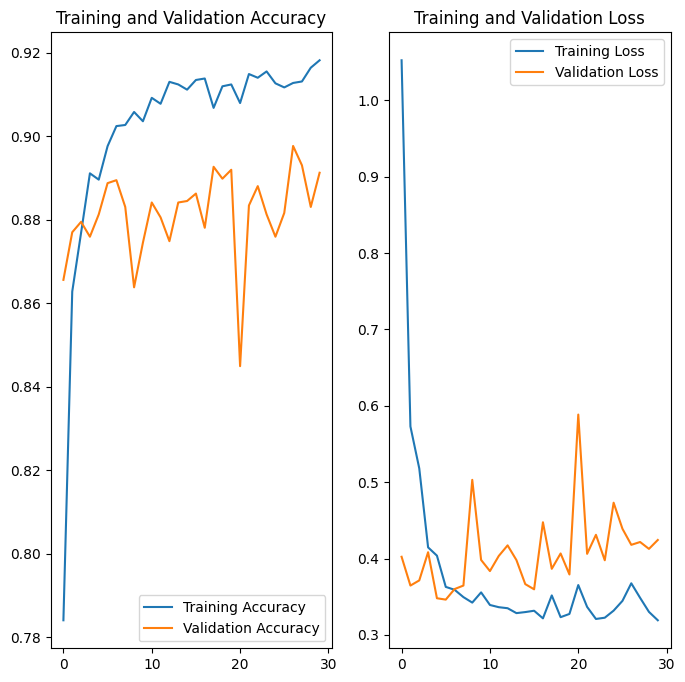

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_transfer_drop.history['accuracy']
val_acc = history_transfer_drop.history['val_accuracy']

loss = history_transfer_drop.history['loss']
val_loss = history_transfer_drop.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* REALIZAMOS DROPOUT A LA SALIDA DEL MODELO DE TRANSFER LEARNING **PERO ENTRENAMOS CON SOLO 10 EPOCAS**

Entrenar el modelo:

In [44]:
# Número de épocas de entrenamiento
EPOCHS = 10
# Entrena el modelo
history_transfer_drop_10ep = model_transfer_drop.fit(
    train_ds_224,
    validation_data=val_ds_224,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9120 - loss: 0.3495 - val_accuracy: 0.8845 - val_loss: 0.4151
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9183 - loss: 0.3233 - val_accuracy: 0.8860 - val_loss: 0.4174
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.9201 - loss: 0.3196 - val_accuracy: 0.8874 - val_loss: 0.4253
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9207 - loss: 0.3237 - val_accuracy: 0.8924 - val_loss: 0.4153
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.9215 - loss: 0.2909 - val_accuracy: 0.8931 - val_loss: 0.4044
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9226 - loss: 0.3054 - val_accuracy: 0.8803 - val_loss: 0.4523
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9091 - loss: 0.3544 - val_accuracy: 0.8831 - val_loss: 0.4659
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.9103 - loss: 0.3726 - 

Visualizar resultados de entrenamiento:

In [45]:
EPOCHS= 10

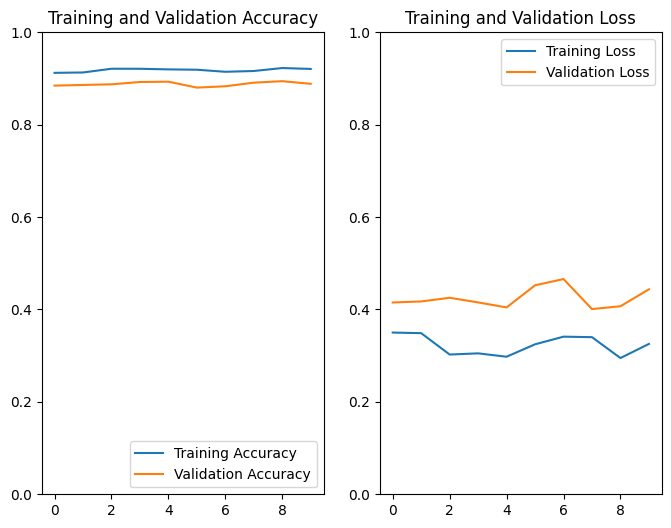

In [46]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_transfer_drop_10ep.history['accuracy']
val_acc = history_transfer_drop_10ep.history['val_accuracy']

loss = history_transfer_drop_10ep.history['loss']
val_loss = history_transfer_drop_10ep.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0, 1])
plt.title('Training and Validation Loss')
plt.show()

### *** Conclusion Modelo de Transfer Learning:**
  Como vimos el transfer learning es una técnica de aprendizaje automático donde un modelo preentrenado en grandes conjuntos de datos se reutiliza como punto de partida para un modelo en clasificacion de imagenes como en nuestro caso.

  Entre sus ventajas, podemos decir que reduce el tiempo de entrenamiento al aprovechar el conocimiento previo del modelo preentrenado, mejora el rendimiento al ser entrenados en grandes conjuntos de datos (lo que les permite generalizar mejor a nuevas tareas), permite ajustar modelos a tareas o dominios relacionados sin necesidad de construir un modelo desde cero.

  En nuestro caso se eligio el modelo EfficienNet preentrenado con el dataset de "imagenet", donde en el primer modelo dio las mejores metricas y como para optimizar el mismo solo podemos trabajar sobre la salida del modelo base (base_model.trainable = False) se decidio regularizar mediante un dropout ("apagamos" aleatoriamente un porcentaje de neuronas), modelo que con menos epocas de entrenamiento inclusive, dio los mejores resultados.

### ***Tabla Comparativa de las mejores redes neuronales para Modelos de Clasificacion*** (*segun su tipo*)

* El mejor modelo de red densa fue el que posee 2 capas ocultas (model_up) y entrenado con imagenes de baja resolucion (75 x 75 pixeles) y 30 epocas
* El mejor modelo de redes convolucionales y densas (model_conv_low) fue el que se entreno con imagenes de baja resolucion (75 x 75 pixeles) y 30 epocas
* El mejor modelo de red residual identidad fue el que posee varios bloques residuales con diferentes valores de filtros (model_resnet_super) y entrenado con imagenes de resolucion original (150 x 150 pixeles) y 20 epocas
+ El mejor modelo de transfer learning utilizando el modelo preentrenado EfficienetB0 fue el modelo transfer learning con dropout a la salida (model_transfer_drop_10ep) con 10 epocas de entrenamiento, si bien las diferencias con el "model_transfer", que fue entrenado con 30 epocas, son muy infimas (tanto el accuracy como el loss)

In [47]:
model_results = {
    'Red Densa': {'accuracy': history_up.history['accuracy'][-1], 'loss': history_up.history['loss'][-1],'val_accuracy': history_up.history['val_accuracy'][-1], 'val_loss': history_up.history['val_loss'][-1]},
    'Red Convolucional': {'accuracy': history_conv_low.history['accuracy'][-1], 'loss': history_conv_low.history['loss'][-1],'val_accuracy': history_conv_low.history['val_accuracy'][-1], 'val_loss': history_conv_low.history['val_loss'][-1]},
    'Red Resnet': {'accuracy': history_resnet_super.history['accuracy'][-1], 'loss': history_resnet_super.history['loss'][-1],'val_accuracy': history_resnet_super.history['val_accuracy'][-1], 'val_loss': history_resnet_super.history['val_loss'][-1]},
    'Red Transfer learning': {'accuracy': history_transfer_drop_10ep.history['accuracy'][-1], 'loss': history_transfer_drop_10ep.history['loss'][-1],'val_accuracy': history_transfer_drop_10ep.history['val_accuracy'][-1], 'val_loss': history_transfer_drop_10ep.history['val_loss'][-1]},
}

#Convertimos el diccionario a dataframe
df = pd.DataFrame.from_dict(model_results, orient='index')
df = df.reset_index()
df = df.rename(columns={'index': 'Modelo'})

print(df)

                  Modelo  accuracy      loss  val_accuracy  val_loss
0              Red Densa  0.676434  0.866944      0.549893  1.284590
1      Red Convolucional  0.839508  0.432815      0.849964  0.433194
2             Red Resnet  0.969362  0.094229      0.809337  0.790053
3  Red Transfer learning  0.920645  0.325420      0.888453  0.443666


### ***Tabla comparativa entre cantidad y tipo de parametros de cada modelo y el accuracy obtenido***

In [54]:
# Obtenemos la cantidad de parametros de cada mejor modelo de clasificacion

total_params_densa = model_up.count_params()
trainable_params_densa = sum([tf.keras.backend.count_params(w) for w in model_up.trainable_weights])

total_params_cnn = model_conv_low.count_params()
trainable_params_cnn = sum([tf.keras.backend.count_params(w) for w in model_conv_low.trainable_weights])

total_params_resnet = model_resnet_super.count_params()
trainable_params_resnet = sum([tf.keras.backend.count_params(w) for w in model_resnet_super.trainable_weights])

total_params_transfer = model_transfer_drop.count_params()
trainable_params_transfer = sum([tf.keras.backend.count_params(w) for w in model_transfer_drop.trainable_weights])

data = {
    'Modelo': ['Densa', 'CNN', 'ResNet', 'Transfer'],
    'Parámetros totales': [total_params_densa, total_params_cnn, total_params_resnet, total_params_transfer],
    'Parámetros entrenables': [trainable_params_densa, trainable_params_cnn, trainable_params_resnet, trainable_params_transfer],
    'Accuracy': [history_up.history['val_accuracy'][-1], history_conv_low.history['val_accuracy'][-1], history_resnet_super.history['val_accuracy'][-1], history_transfer_drop_10ep.history['val_accuracy'][-1]]
}
df = pd.DataFrame(data)
print(df)

     Modelo  Parámetros totales  Parámetros entrenables  Accuracy
0     Densa             1082342                 1082342  0.549893
1       CNN               43350                   43350  0.849964
2    ResNet               64486                   63878  0.809337
3  Transfer             4057257                    7686  0.888453


## **** Conclusiones Finales del Trabajo Practico***

**1 - Cantidad de parametros totales, entrenables vs. accuracy:**

  * Observamos que con ciertas arquitecturas de modelos de clasificacion con mucha menos cantidad de parametros *finalmente* entrenables, los resultados obtenidos fueron mejores en cuanto a la metrica elegida ("accuracy") como a la funcion de perdida ("loss").

  * Transfer Learning logra la mayor precisión (Accuracy: 0.888), pero a costa de un número significativamente mayor de parámetros totales. Solo una pequeña fracción de estos parámetros son entrenables, lo que indica el uso de un modelo pre-entrenado.

  * CNN ofrece un buen balance entre precisión (Accuracy: 0.849) y eficiencia, con un número mucho menor de parámetros que Transfer Learning. Todos sus parámetros son entrenables.

  * ResNet tiene una precisión ligeramente inferior a CNN (Accuracy: 0.809) y un número de parámetros similar, aunque también con la mayoría entrenables.

  * Densa presenta la menor precisión (Accuracy: 0.549) y un número alto de parámetros.

**2 - Machine Learning: arte vs. ciencia:**  

  * Comprobamos, que mas alla de la base teorica, las implementaciones probadas y los conceptos sobre la optimizacion de hiperparametros que tienen los distintos modelos de red que vimos, los resultados finales que se obtienen dependen no solo del conjunto de datos con el cual se trabaja, sino tambien de la motivacion y experiencia de ir probando, modificando, "tocando" el modelo, verificando y preguntarse "por que" sucede tal cosa, por ejemplo, si hay overfitting: modelo muy complejo, bajar la resolucion de las imagenes, tecnicas de regularizacion, Early Sttoping, etc.


**3 - -Tipos de Datos:**

  Vimos distintos tipos de datos en los 3 Ejercicios planteados en este TP:

  * Datos Tabulares: como las notas y demas caracteristicas del dataset del Ejercicio 1 (regresion)

  * Datos tipo Keypoints: donde cada objeto hand_landmarks (a traves de la libreria MediaPipe) contiene una lista de puntos de referencia, las coordenadas de los puntos de la mano del Ejercicio 2 (scripts)

  * Datos tipo Imagenes: como el dataset del Ejercicio 3


**4 - Redes densas la de peor resultado, las CNN mucho mejor para esta actividades:**

  * En general, se puede concluir que las redes CNN son mejores para clasificar imágenes en comparación con las redes densas, y en muchos casos también superan a los modelos de transfer learning como EfficientNet y ResNet, especialmente cuando se trata de conjuntos de datos específicos o con recursos computacionales limitados.

  * CNN vs. Redes densas: Las CNN tienen una arquitectura especializada para  procesar datos de imágenes, aprovechando la estructura espacial de la pixeles mediante filtros convolucionales. Esto les permite aprender características relevantes de las imágenes de manera más eficiente que las redes densas, que tratan cada pixel como una entrada independiente.

  * CNN vs. Transfer Learning (EfficientNet) - ResNet: Los modelos de transfer learning como EfficientNet y ResNet son muy poderosos y generalmente ofrecen un buen rendimiento en tareas de clasificación de imágenes. Sin embargo, tienen algunas desventajas en comparación con las CNN:
    * Tamaño y complejidad: Los modelos de transfer learning suelen ser mucho más grandes y complejos que las CNN, lo que requiere más recursos computacionales para entrenar y ejecutar.
    * Especificidad del conjunto de datos: Si bien los modelos de transfer learning se entrenan previamente en grandes conjuntos de datos, es posible que no se adapten perfectamente a un conjunto de datos específico. En estos casos, una CNN entrenada desde cero en el conjunto de datos objetivo puede ofrecer un mejor rendimiento.
    * Interpretabilidad: Las CNN son generalmente más fáciles de interpretar que los modelos de transfer learning, lo que puede ser importante en algunas aplicaciones.
  
  En resumen:

  Las CNN son una buena opción para la clasificación de imágenes en general, especialmente cuando se trabaja con conjuntos de datos específicos o con recursos computacionales limitados.
  Los modelos de transfer learning como EfficientNet y ResNet pueden ofrecer un mejor rendimiento en algunos casos, pero son más complejos y requieren más recursos.
  La elección del mejor modelo depende del conjunto de datos específico, los recursos disponibles y los requisitos de la aplicación.
  